In [1]:
!pip install gradio scikit-learn opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00


In [2]:
import numpy as np
from PIL import Image
import cv2
import gradio as gr
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


In [17]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

# SGD - improved
sgd_clf = SGDClassifier(
    loss="log_loss", max_iter=3000, tol=1e-3, alpha=0.0001, random_state=42
)
sgd_clf.fit(X_train, y_train)

# Random Forest - improved
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=5, random_state=42
)
rf_clf.fit((X_train * 255).astype(np.uint8), y_train)


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [24]:
y_pred_sgd = sgd_clf.predict(X_test)

In [25]:
from sklearn.metrics import classification_report

print("SGD Classifier - Classification Report")
print(classification_report(y_test, y_pred_sgd))


SGD Classifier - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       986
           1       0.94      0.98      0.96      1125
           2       0.93      0.88      0.91       999
           3       0.85      0.90      0.88      1020
           4       0.95      0.88      0.92       975
           5       0.90      0.83      0.86       902
           6       0.94      0.97      0.95       982
           7       0.94      0.92      0.93      1042
           8       0.87      0.85      0.86       975
           9       0.84      0.90      0.87       994

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [28]:
y_pred_rf = rf_clf.predict((X_test * 255).astype(np.uint8))

In [29]:
from sklearn.metrics import classification_report

print("RandomForestClassifier - Classification Report")
print(classification_report(y_test, y_pred_rf))


RandomForestClassifier - Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       986
           1       0.98      0.99      0.98      1125
           2       0.96      0.97      0.97       999
           3       0.96      0.95      0.96      1020
           4       0.97      0.96      0.97       975
           5       0.97      0.96      0.97       902
           6       0.97      0.99      0.98       982
           7       0.97      0.97      0.97      1042
           8       0.95      0.95      0.95       975
           9       0.93      0.94      0.94       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [18]:
def preprocess_sketch(input_data):
    img = np.array(input_data["composite"]).astype("uint8")
    img = Image.fromarray(img).convert("L")
    img_np = np.array(img)

    _, thresh = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    x, y, w, h = cv2.boundingRect(contours[0])
    digit = thresh[y:y+h, x:x+w]
    digit = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_AREA)

    canvas = np.zeros((28, 28), dtype=np.uint8)
    canvas[4:24, 4:24] = digit
    canvas = 255 - canvas
    return canvas


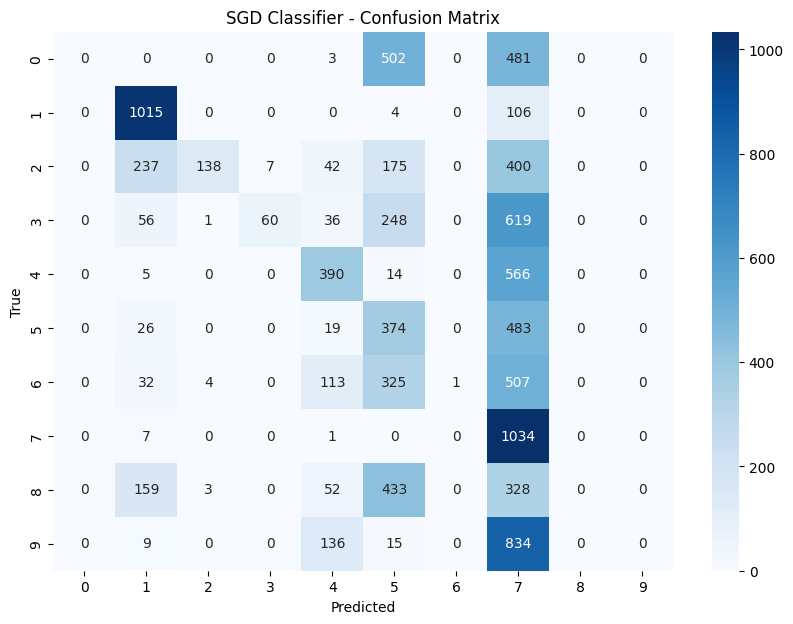

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_sgd)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SGD Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


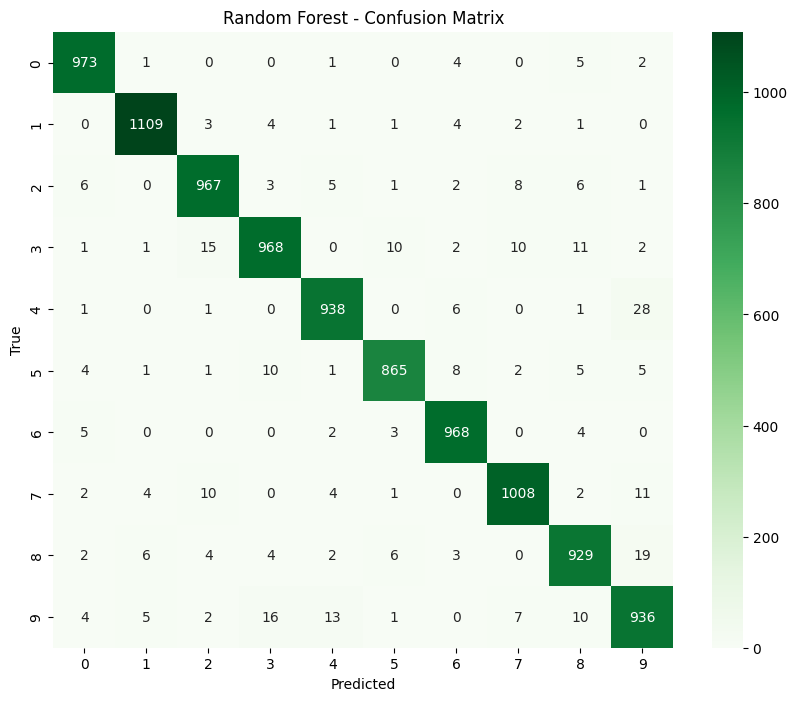

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


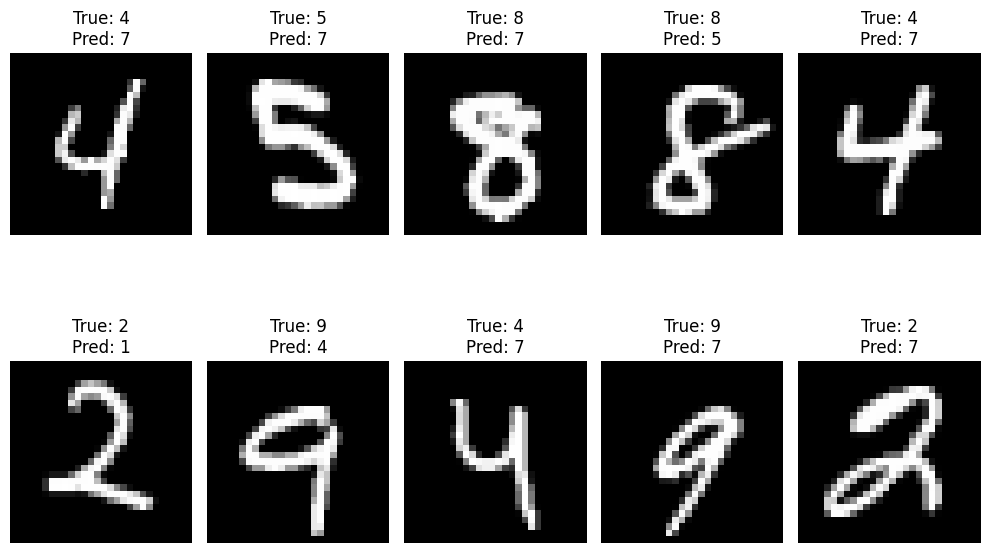

In [35]:
import numpy as np

misclassified_idx = np.where(y_test != y_pred_sgd)[0]

# Optional: show the first 10 worst predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for i, idx in enumerate(misclassified_idx[:10]):
    img = X_test[idx].reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred_sgd[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


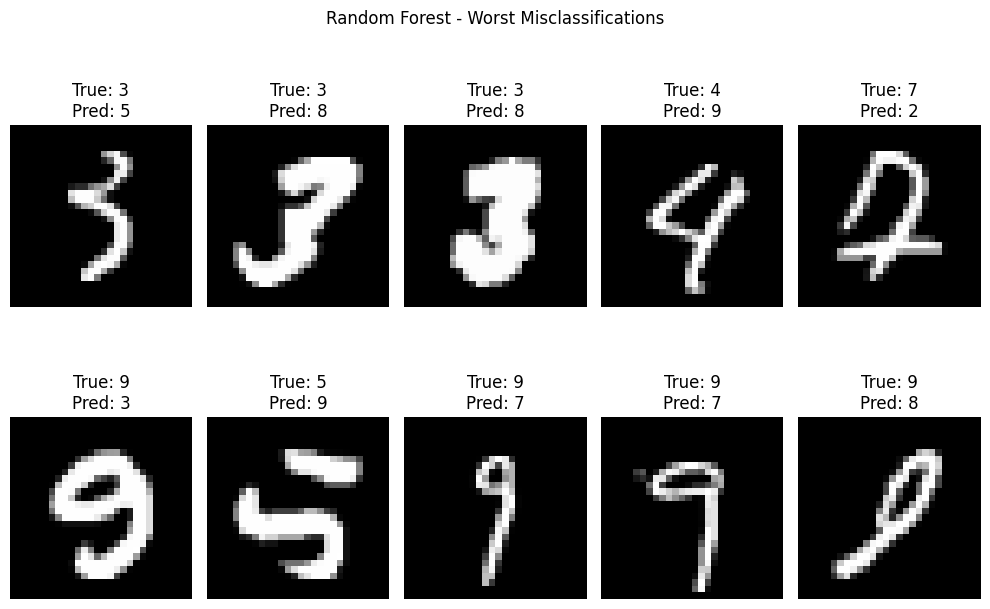

In [36]:
import numpy as np
import matplotlib.pyplot as plt

misclassified_idx_rf = np.where(y_test != y_pred_rf)[0]

plt.figure(figsize=(10, 7))
for i, idx in enumerate(misclassified_idx_rf[:10]):
    img = X_test[idx].reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred_rf[idx]}")
    plt.axis("off")
plt.suptitle("Random Forest - Worst Misclassifications")
plt.tight_layout()
plt.show()


In [37]:
def predict_digit(input_data, model_choice):
    canvas = preprocess_sketch(input_data)
    if canvas is None:
        return "Draw a digit"

    img = canvas / 255.0
    img = img.reshape(1, -1)

    if model_choice == "SGD":
        return int(sgd_clf.predict(img)[0])
    else:
        return int(rf_clf.predict((img * 255).astype(np.uint8))[0])


In [38]:
gr.Interface(
    fn=predict_digit,
    inputs=[
        gr.Sketchpad(image_mode="L", width=280, height=280, label="Draw a digit"),
        gr.Radio(["SGD", "Random Forest"], value="SGD", label="Choose Model")
    ],
    outputs="label",
    title="Digit Recognition)",
    live=True
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72f1c65a8625e9f423.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
def debug_preprocessing(input_data):
    canvas = preprocess_sketch(input_data)
    if canvas is None:
        return "Nothing detected."

    import matplotlib.pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(canvas, cmap="gray")
    plt.title("Processed Image Sent to Model")
    plt.axis("off")
    plt.show()

    return "If this image looks clear and centered, prediction should work."

gr.Interface(
    fn=debug_preprocessing,
    inputs=gr.Sketchpad(image_mode="L", width=280, height=280, label="Draw a digit to preview"),
    outputs="text",
    title="🧠 Visual Debug — What Your Model Actually Sees"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aad70b7cabb40eb0a0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
